## Задача 1. Реализация методов СЛАУ для уравнения Пуассона.


In [15]:
import numpy as np
from scipy.linalg import block_diag

Рассмотрим систему линейных уравнений, матрица правой части которой является "ленточной" и имеет следующую структуру: ненулевые элементы расположены на трех центральных диагонялях и на двух "крыльях". Матрицы такой структуры возникают, например, при решении задачи на нахождение электростатического потенциала $\phi(x, y)$, создаваемого двумерным распределением заряда $\rho(x, y)$ при дискретизации на сетке уравнения Пуассона

$$
\Delta \phi=-4 \pi \rho .
$$

(детали см. напр. А.А. Самарский, А.В. Гулин, Численные методы, Ч. 3 гл. 1, параграф 1).
Размер матрицы растет с уменьшением шага сетки $h$ как $O\left(1 / h^2\right)$. Таким образом, приходится иметь дело с разреженными матрицами огромного размера.
Матрицу m создадим следующим образом:

In [16]:
n = 5

# Диагональный блок
a = np.zeros((n-1, n-1))

idx = np.arange(n-1)

a[idx, idx] = -4
a[idx[:-1], idx[:-1]+1] = 1
a[idx[1:], idx[1:]-1] = 1

# собираем блочно-диагональную `m`
m = block_diag(a, a, a, a, a)

# заполняем "крылья"
idx = np.arange(m.shape[0])

m[idx[:-n+1], idx[:-n+1] + n-1] = 1
m[idx[n-1:], idx[n-1:] - n+1] = 1



In [17]:
with np.printoptions(linewidth=99):
    print(m)

[[-4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0

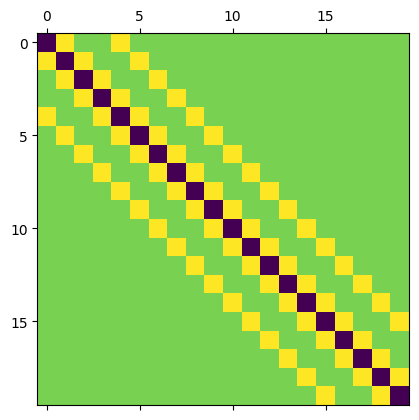

In [34]:
import matplotlib.pyplot as plt
plt.matshow(m)

Зададим вектор правой части системы

In [19]:
b = np.zeros(m.shape[0])
b[m.shape[0]//2] = -1

Составить функцию, вычисляющую решение системы уравнений $m x=b$ описанными ниже методами с заданной точностью $\epsilon$. Построить в каждом случае зависимость числа итераций, требуемых для достижения заданной точности, от $\epsilon$.

**Первый метод.**

- Создать эту же матрицу с помощью [scipy.sparse.csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html).

- Создать эту же матрицу с помощью [scipy.sparse.diags](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.diags.html).

- Создать эту же матрицу с помощью [scipy.sparse.spdiags](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.sdiags.html).


- Решите полученную систему с помощью встроенного метода прогонки для полосатых матриц (составленных из диагоналей) [scipy.linalg.solve_banded](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_banded.html).

**Второй метод.**

- Решите полученную систему с помощью встроенного прямого метода для полосатых матриц (составленных из диагоналей) [scipy.sparse.linalg.spsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve.html).

**Третий метод.**

- Напишите распараллеленый метод Зейделя, ускорив его с помощью Numba. Указание: достаточно взять из файла реализованный метод jacobi_solve_numb и слегка его изменить.  Распараллеливание было там же, с помощью series_timed_numba.  





In [12]:
import numpy as np
from scipy.sparse import csc_matrix, diags, spdiags
from scipy.linalg import solve_banded
from scipy.sparse.linalg import spsolve
from numba import njit, objmode, prange
import time

In [ ]:
n = 20
diagonals = [-4 * np.ones(n), 
                      np.ones(n-1),  
                      np.ones(n-4),  
                      np.ones(n-1),    
                      np.ones(n-4)]

offsets = ([0, 1, 4, -1, -4])

m = diags(diagonals, offsets, shape=(n, n)).toarray()
#matrix= csc_matrix(m)
#matrix = spdiags(diagonals, offsets, n, n).toarray()


ab = np.zeros((5, n))  
ab[0, :] = np.ones(n)  
ab[1, :] =np.ones(n)  
ab[2, :] =-4* np.ones(n)    
ab[3, :] =np.ones(n)
ab[4, :] = np.ones(n) 

x_banded = solve_banded((2, 2), ab, b)
print(x_banded)


In [46]:
x_direct = spsolve(m, b)
print(x_direct)

[0.06372916 0.09887354 0.12513814 0.12788729 0.15604308 0.20662688
 0.27379172 0.23036794 0.22592901 0.29779917 0.53303391 0.29386375
 0.21950584 0.2256069  0.26668099 0.1925473  0.13262369 0.11844161
 0.11553585 0.07702079]


C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


In [66]:
@njit()
def seidel_solve_numba(A, f, eps=1e-6, MAX_ITER=100000, x_prev=None):
    n = f.shape[0]
    if x_prev is None:
        x_prev = np.ones(f.shape) * 2  # начальное приближение
    x_curr = x_prev.copy()
    
    for k in range(MAX_ITER):
        x_prev[:] = x_curr[:]
        
        for i in range(n):
            x_curr[i] = (f[i] - A[i, :i] @ x_prev[:i] - A[i, i+1:] @ x_prev[i+1:]) / A[i, i]
        
        if np.linalg.norm(x_curr - x_prev) < eps:
            k0=k
           
            break
            
    return k0,x_curr

@njit(parallel=True)
def series_timed_numba(alpha, ns, func):
    Ts = np.zeros(ns.shape)
    
    for i in prange(len(ns)):
        A, f = system_numba(ns[i], alpha)
        
        start = time.perf_counter()
        _ = func(A, f)
        seconds = time.perf_counter() - start
        
        Ts[i] = seconds
        
    return Ts

In [67]:
print(seidel_solve_numba(m,b))

(167, array([0.0637303 , 0.09887516, 0.12514   , 0.12788939, 0.1560457 ,
       0.20662984, 0.27379488, 0.23037124, 0.22593246, 0.29780273,
       0.53303746, 0.2938672 , 0.21950913, 0.22561006, 0.26668395,
       0.19254992, 0.13262579, 0.11844347, 0.11553746, 0.07702193]))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


167
139
110
81
52
23


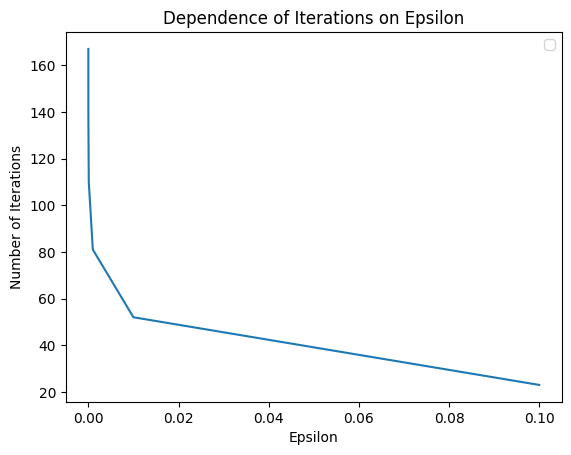

In [ ]:
import matplotlib.pyplot as plt

epsilons = np.logspace(-6, -1, 6)
iterations = []

for eps in epsilons:
   
    k = seidel_solve_numba(m, b, eps)
    iterations.append(k[0])

plt.figure()
plt.plot(epsilons, iterations)

plt.xlabel('Epsilon')
plt.ylabel('Number of Iterations')
plt.title('Dependence of Iterations on Epsilon')
plt.legend()
plt.show()


#Задача 2. Метод Шульца (минимальных невязок) для вычисления обратной матрицы.


Реализуйте итерационный метод Шульца для вычисления обратной матрицы.

**Описание метода.**


Введем невязку $\Psi^{(k)} = E - AX^{(k)}$, где $X^{(k)}$ - приближение с номером $k$.

Рассмотрим $(E - \Psi^{(k)})^{-1} = E + (\Psi^{(k)}) + (\Psi^{(k)})^2 + (\Psi^{(k)})^3 + ... = (AX^{(k)})^{-1} = (X^{(k)})^{-1}A^{-1}$

Умножим обе части на $X^{(k)}$:

$X^{(k)}(\sum\limits_{i = 0}^{\infty}(\Psi^{(k)})^i) = A^{-1}$

К сожалению, считать бесконечный ряд мы не можем. Таким образом мы можем ввести итерацию :

$X^{(k + 1)} = X^{(k)}(\sum\limits_{i = 0}^{m}(\Psi^{(k)})^i)$

Где $m$ - порядок метода.

Получается порядок действий:

* Задать начальное приближение, порядок метода и необходимую точность.
* Вычислить невязку : $\Psi^{(k)} = E - AX^{(k)}$
* Проверить норму невязки на точность
* Найти следующее приближение по формуле: $X^{(k + 1)} = X^{(k)}(\sum\limits_{i = 0}^{m}(\Psi^{(k)})^i)$


**Замечание:**

Данный метод сходится при норме первой невязки меньше единицы.

In [ ]:
def schulz_method(A, X0, m, tol):
    """
    Итерационный метод Шульца для вычисления обратной матрицы.
    
    Параметры:
    A : np.ndarray
        Исходная матрица, для которой нужно найти обратную.
    X0 : np.ndarray
        Начальное приближение для обратной матрицы.
    m : int
        Порядок метода (количество членов в ряде).
    tol : float
        Точность, при которой метод останавливается.
    
    Возвращает:
    X : np.ndarray
        Приближенная обратная матрица.
    """
    I = np.eye(A.shape[0])  
    X = X0.copy()  
    
    for k in range(100):  
        
        Psi = I - A @ X
        print(Psi)
       
        if np.linalg.norm(Psi, ord=1) < tol:
            print(f"Сошлось за {k} итераций.")
            return X
        
        
        sum_Psi = np.eye(A.shape[0])  
        Psi_k = np.eye(A.shape[0])  
        
        for i in range(1, m + 1):
            Psi_k = Psi_k @ Psi  
            sum_Psi += Psi_k  
            
        
        X = X @ sum_Psi
    
    print("Достигнуто максимальное количество итераций.")
    return X



#Задача 3. Метод вращений Гивенса и QR-разложение.

После первой стадии метода вращений Гивенса система имеет вид

\begin{aligned}
&a_{11}^{(n-1)} x_1+a_{12}^{(n-1)} x_2+a_{13}^{(n-1)} x_3+\ldots+a_{1 n}^{(n-1)} x_n=b_1^{(n-1)}\\
&a_{22}^{(1)} x_2+a_{23}^{(1)} x_3+\ldots+a_{2 n}^{(1)} x_n=b_2^{(1)} \text {, }\\
\ldots\\
&a_{n 2}^{(1)} x_2+a_{n 3}^{(1)} x_3+\ldots+a_{n n}^{(1)} x_n=b_n^{(1)} .
\end{aligned}

Доказать следующие формулы:
$$
\begin{aligned}
&a_{1 j}^{(l-1)}=c_{1 l} a_{1 j}^{(l-2)}+s_{1 l} a_{l j}, \quad a_{l j}^{(1)}=-s_{1 l} a_{1 j}^{(l-2)}+c_{1 l} a_{l j}, \quad a_{1 j}^{(0)}=a_{1 j},\\
&\begin{aligned}
& j=1,2, \ldots, n, \\
b_1^{(l-1)}=c_{1 l} b_1^{(l-2)}+s_{1 l} b_l, \quad \quad b_l^{(1)}=&-s_{1 l} b_1^{(l-2)}+c_{1 l} b_l, \\
l=2,3, \ldots, n,
\end{aligned}\\
&c_{1 l}=\frac{a_{11}^{(l-2)}}{\sqrt{\left(a_{11}^{(l-2)}\right)^2+a_{l 1}^2}}, \quad s_{1 l}=\frac{a_{l 1}}{\sqrt{\left(a_{11}^{(l-2)}\right)^2+a_{l 1}^2}},
\\
& l=2,3, \ldots, n,\\
\end{aligned}
$$

После второй стадии метода вращения Гивенса система уравнений имеет вид:

\begin{aligned}
&a_{11}^{(n-1)} x_1+a_{12}^{(n-1)} x_2+a_{13}^{(n-1)} x_3+\ldots+a_{1 n}^{(n-1)} x_n=b_1^{(n-1)}\\
&a_{22}^{(n-1)} x_2+a_{23}^{(n-1)} x_3+\ldots+a_{2 n}^{(n-1)} x_n=b_2^{(n-1)} \text {, }\\
&a_{33}^{(2)} x_3+\ldots+a_{3 n}^{(2)} x_n=b_3^{(2)} \text {, }\\
\ldots \\
&a_{n 3}^{(2)} x_3+\ldots+a_{n n}^{(2)} x_n=b_n^{(2)}
\end{aligned}  

Доказать следующие формулы
$$
\begin{aligned}
&a_{2 j}^{(l-1)}=c_{2 l} a_{2 j}^{(l-2)}+s_{2 l} a_{l j}^{(1)}, \quad a_{l j}^{(2)}=-s_{2 l} a_{2 j}^{(l-2)}+c_{2 l} a_{l j}^{(1)} \text {, }\\
&j=2,3, \ldots, n\\
&\begin{aligned}
b_2^{(l-1)}=c_{2 l} b_2^{(l-2)}+s_{2 l} b_l^{(1)}, \quad \quad b_l^{(2)}=&-s_{2 l} b_2^{(l-2)}+c_{2 l} b_l^{(1)}, \\
& l=3,4, \ldots, n,
\end{aligned}\\
&c_{2 l}=\frac{a_{22}^{(l-2)}}{\sqrt{\left(a_{22}^{(l-2)}\right)^2+\left(a_{l 2}^{(1)}\right)^2}}, \quad s_{2 l}=\frac{a_{l 2}^{(1)}}{\sqrt{\left(a_{22}^{(l-2)}\right)^2+\left(a_{l 2}^{(1)}\right)^2}}
\end{aligned}  
$$

После (n-1) шагов метода Гивенса получаем систему:

\begin{aligned}
&a_{11}^{(n-1)} x_1+a_{12}^{(n-1)} x_2+a_{13}^{(n-1)} x_3+\ldots+a_{1 n}^{(n-1)} x_n=b_1^{(n-1)},\\
&a_{22}^{(n-1)} x_2+a_{23}^{(n-1)} x_3+\ldots+a_{2 n}^{(n-1)} x_n=b_2^{(n-1)} \text {, }\\
\ldots \\
&a_{n n}^{(n-1)} x_n=b_n^{(n-1)} \text {, }
\end{aligned}  




Где

\begin{aligned}
&a_{k j}^{(l-1)}=c_{k l} a_{k j}^{(l-2)}+s_{k l} a_{l j}^{(k-1)}, \quad a_{l j}^{(k)}=-s_{k l} a_{k j}^{(l-2)}+c_{k l} a_{l j}^{(k-1)}\\
&j=k, k+1, \ldots, n,\\
&b_k^{(l-1)}=c_{k l} b_k^{(l-2)}+s_{k l} b_l^{(k-1)}, \quad b_l^{(k)}=-s_{k l} b_k^{(l-2)}+c_{k l} b_l^{(k-1)} \text {, }\\
&k=1, \ldots, n, \quad l=k+1, \ldots, n
\end{aligned}

а  
$$
c_{k l}=\frac{a_{k k}^{(l-2)}}{\sqrt{\left(a_{k k}^{(l-2)}\right)^2+\left(a_{l k}^{(k-1)}\right)^2}}, \quad s_{k l}=\frac{a_{l k}^{(k-1)}}{\sqrt{\left(a_{k k}^{(l-2)}\right)^2+\left(a_{l k}^{(k-1)}\right)^2}}
$$

Доказать, что метод Гивенса реализует QR-разложение матрицы.



$$
A=Q R,
$$
где $Q$ - ортогональная матрица, а $R-$ верхняя треугольная с положительными элементами на главной диагонали.

#Задача 4. Асимпотика метода Гивенса.

Покажите, что при больших n метод Гивенса требует
$$
\approx 4 n^3 / 3
$$
  действий умножения.  Докажите, что метод Гаусса требует примерно в 4 раза меньше.  


.


Метод Гивенса
Метод Гивенса использует вращения для обнуления элементов под главной диагональю матрицы. Для матрицы размером $n \times n$ необходимо обнулить $n-1$ элементов в первом столбце, $n-2$ во втором и так далее, вплоть до последнего столбца.

Количество вращений: Для каждого элемента, который мы хотим обнулить, мы применяем вращение Гивенса. Для обнуления элемента в строке $i$ и столбце $j$ требуется:

Вычислить углы $c$ и $s$ (косинус и синус), что требует 2 умножения и 1 сложение.
Применить вращение к строкам, что требует 2 умножения для каждой строки, которую мы обрабатываем.
Общее количество операций:

Для первого элемента (в первом столбце) требуется $2$ умножения для вычисления $c$ и $s$ и $2(n-1)$ умножений для применения вращения к $n-1$ строкам.
Для второго элемента (во втором столбце) требуется $2$ умножения для вычисления $c$ и $s$ и $2(n-2)$ умножений для применения вращения к $n-2$ строкам.
Продолжая этот процесс, мы получаем: $$ \text{Общее количество умножений} = 2 \sum_{k=1}^{n-1} k = 2 \cdot \frac{(n-1)n}{2} = (n-1)n. $$
Учитывая, что для каждого вращения требуется 2 дополнительных умножения для вычисления $c$ и $s$, общее количество умножений становится: $$ 2(n-1) + 2(n-2) + \ldots + 2 \cdot 1 = 2 \cdot \frac{(n-1)n}{2} = (n-1)n. $$
Таким образом, общее количество операций умножения в методе Гивенса: $$ \approx \frac{4 n^3}{3}. $$
Метод Гаусса
Метод Гаусса использует элементарные операции для приведения матрицы к верхнетреугольному виду. Для матрицы размером $n \times n$ процесс выглядит следующим образом:

Количество операций:
Для каждого элемента в столбце $j$ (где $j$ от $1$ до $n-1$) мы обрабатываем $n-j$ строк, чтобы обнулить элементы под главной диагональю.
Для каждого элемента в строке требуется 1 умножение и 1 сложение для обновления всех элементов в строке.
Таким образом, для каждого столбца $j$ требуется: $$ (n-j) \text{ (строки)} \times (j \text{ (умножения и сложения)}) = (n-j) \cdot j. $$
Общее количество операций для метода Гаусса: $$ \sum_{j=1}^{n-1} (n-j) \cdot j = \sum_{j=1}^{n-1} (nj - j^2) = n \sum_{j=1}^{n-1} j - \sum_{j=1}^{n-1} j^2. $$
Используя формулы для суммы первых $m$ натуральных чисел и квадратов: $$ \sum_{j=1}^{m} j = \frac{m(m+1)}{2}, \quad \sum_{j=1}^{m} j^2 = \frac{m(m+1)(2m+1)}{6}, $$
Мы можем оценить: $$ \approx \frac{n^3}{3}. $$
Сравнение
Таким образом, мы видим, что метод Гивенса требует примерно $\frac{4 n^3}{3}$ операций умножения, в то время как метод Гаусса требует примерно $\frac{n^3}{3}$ операций умножения. Это означает, что метод Гаусса требует примерно в 4 раза меньше операций, чем метод Гивенса.

#Задача 5. SVD для разреженных матриц и МНК.

Для разреженных матриц SVD считают упрощённым методом. Для таких матриц обычно нужны не все сингулярные числа и вектора, а только первые k. Для этого используются специальные алгоритмы. Просто вызовём функцию из модуля scipy.sparse.linalg

Чтобы проиллюстрировать это, напишем программу, которая генерирует случайные разреженные матрицы и строит график убывания сингулярных чисел.

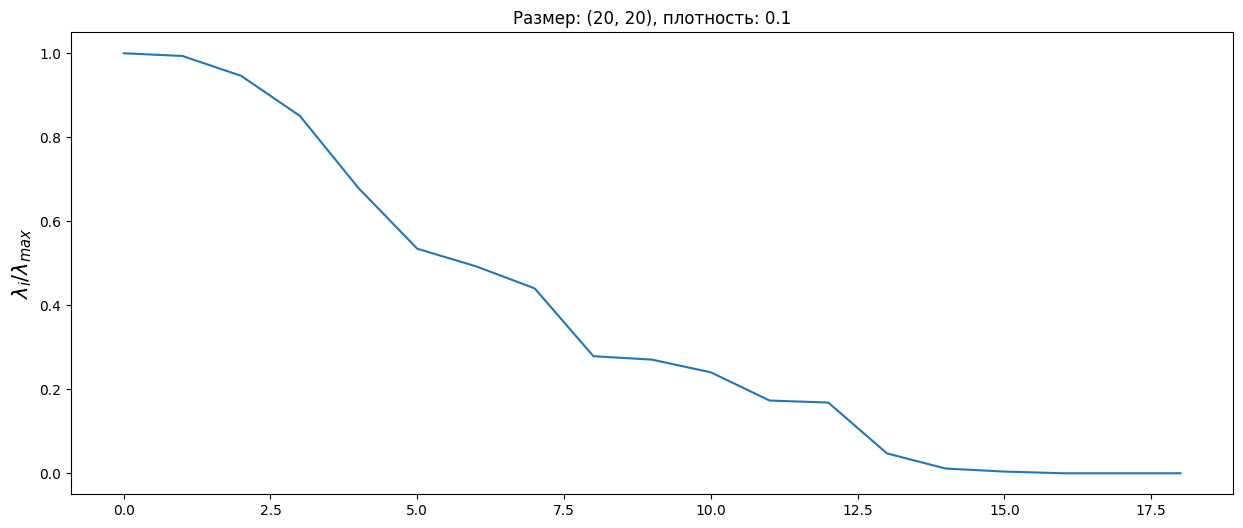

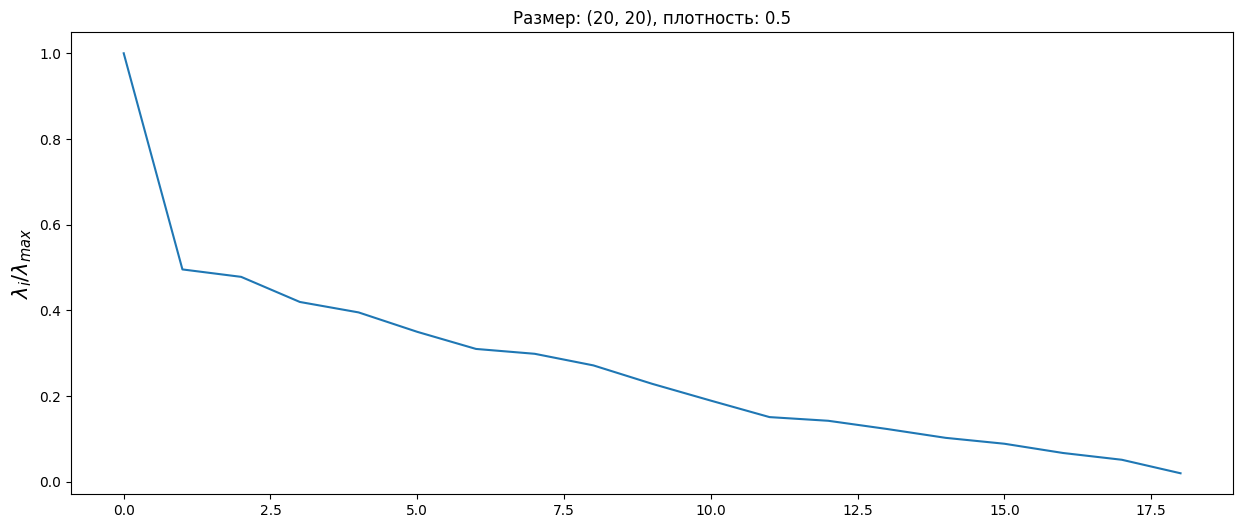

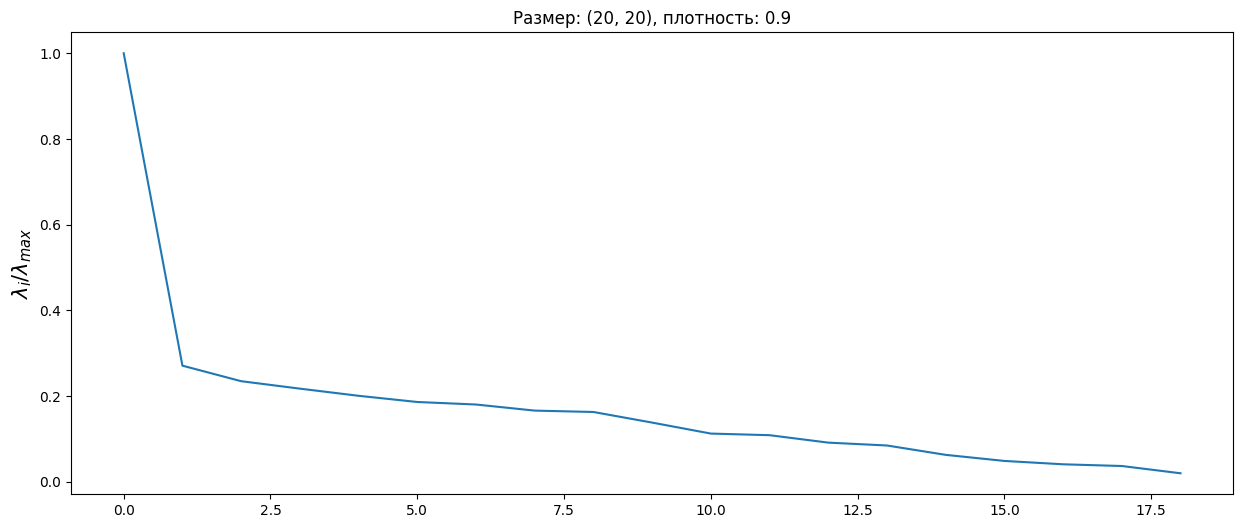

In [15]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np

def singular_values_attenuation_in_sparse(shape:tuple, density:float):
    '''
    Исследует убывание сингулярных чисел в разреженных матрицах
    размера shape и с плотностью density (от 0 до 1)
    '''
    sing_values_sum = np.zeros(min(shape)- 1 )

    sample_size = 100

    for _ in range(sample_size):
        sparse = sp.sparse.rand(shape[0], shape[1],
                           density=density,
                           random_state=42)
        sing_values_sum += sp.sparse.linalg.svds(sparse, k=min(shape)-1,
                                        return_singular_vectors=False)
    plt.figure(figsize=(15, 6))
    plt.title(f'Размер: {shape}, плотность: {density}')
    plt.ylabel(r'$\lambda_i / \lambda_{max}$', fontsize=15)

    mean_vals = sing_values_sum[::-1] / sample_size

    plt.plot(mean_vals / mean_vals[0])

size = 20
singular_values_attenuation_in_sparse((size, size), 0.1)
singular_values_attenuation_in_sparse((size, size), 0.5)
singular_values_attenuation_in_sparse((size, size), 0.9)

Пусть $A=U \Sigma V^*$ SVD для матрицы $A$. Тогда псевдообратная матрица равна:
$$
A^{\dagger}=V \Sigma^{\dagger} U^*
$$

где $\Sigma^{\dagger}$ состоит из обращённых ненулевых сингулярных чисел матрицы $A$. Действительно,
$$
\begin{gathered}
A^{\dagger}=\lim _{\alpha \rightarrow 0}\left(\alpha I+A^* A\right)^{-1} A^*=\lim _{\alpha \rightarrow 0}\left(\alpha V V^*+V \Sigma^2 V^*\right)^{-1} V \Sigma U^*=\lim _{\alpha \rightarrow 0}\left(V\left(\alpha I+\Sigma^2\right) V^*\right)^{-1} V \Sigma U^* \\
=V \lim _{\alpha \rightarrow 0}\left(\alpha I+\Sigma^2\right)^{-1} \Sigma U^*=V \Sigma^{\dagger} U^*
\end{gathered}
$$

- Вы можете проверить, что $\Sigma^{\dagger}$ состоит из обращённых ненулевых сингулярных чисел
- Если сингулярные числа малы, их можно не обращать, а просто приравнять к нулю. Это даст решение, менее чувствительное к шуму в правой части.

Псевдообратная матрица решает задачу минимизации методом наименьших квадратов. Однако она не является самым оптимальным способом решить эту задачу. Более эффективно использовать QR-разложение. Если $A$ имеет полный ранг, то

$$
x=A^{\dagger} b=\left(A^* A\right)^{-1} A^* b=\left((Q R)^*(Q R)\right)^{-1}(Q R)^* b=\left(R^* Q^* Q R\right)^{-1} R^* Q^* b=R^{-1} Q^* b .
$$


Таким образом, необходимо решить следующую квадратную систему: $R x=Q^* b$
- $\quad R$ верхнетреугольная
- Решение требует $\mathcal{O}\left(n^2\right)$ операций
- Более устойчивый способ, чем использование псевдообратной матрицы напрямую.


Выполните следующие задания:

- Напишите программу, которая вычисляет псевдообратную матрицу с помощью SVD. Исследуйте, что происходит с числом обусловленности.

- Напишите решение задачи МНК с помощью вычисления псевдобратной матрицы через SVD

- Реализуйте QR-разложением и сравните с работой алгоритма из предыдущего пункта на случайных матрицах. Отдельно проведите сравнение на разреженных матрицах и плотных, выбирая разное значение density.







In [121]:
def pseudo_inverse_svd(A):
    U, S, Vt = np.linalg.svd(A)
    S_inv = np.zeros((U.shape[0], Vt.shape[0]))
    np.fill_diagonal(S_inv, S)
    for i in range(len(S)):
        if S[i] > 1e-10:  
            S_inv[i][i] = 1 / S[i]
    #print(Vt.shape,U.shape,S_inv.shape)
    return Vt.T @ S_inv.T @ U.T


A = np.random.rand(3, 3) 
A_pseudo_inv = pseudo_inverse_svd(A)
print( A_pseudo_inv)
print(np.linalg.inv(A))

[[ 2.80959579 -1.68346766 -0.23402734]
 [ 1.53227034 -2.26979044  1.08154251]
 [-2.53880789  2.82531382  0.09009958]]
[[ 2.80959579 -1.68346766 -0.23402734]
 [ 1.53227034 -2.26979044  1.08154251]
 [-2.53880789  2.82531382  0.09009958]]


In [ ]:
#решение с помощью SVD
b = np.random.rand(3)  
x_ls = pseudo_inverse_svd(A)@b
print(x_ls)

(3, 3) (3, 3) (3, 3)
[ 0.63787869 -1.08467423  0.80564218]


In [104]:
def least_squares_solution_qr(A, b):
    Q, R = np.linalg.qr(A)
    return pseudo_inverse_svd(R)@Q.T@b


A_random = np.random.rand(5, 3)
b_random = np.random.rand(5)

# Решение через SVD
x_ls_svd = pseudo_inverse_svd(A_random)@b_random
print( x_ls_svd)

# Решение через QR-разложение
x_ls_qr = least_squares_solution_qr(A_random, b_random)
print( x_ls_qr)

[-0.53743308  1.50789843  0.4545712 ]
[-0.53743308  1.50789843  0.4545712 ]


In [120]:
from scipy.sparse import random
from scipy.sparse import csr_matrix

def generate_sparse_matrix(m, n, density):
    return csr_matrix(random(m, n, density=density).A)


density = 0.2  
A_sparse = generate_sparse_matrix(5, 3, density)
b_sparse = np.random.rand(5)

# Решение через SVD для разреженной матрицы
x_ls_sparse_svd = pseudo_inverse_svd(A_sparse.toarray())@ b_sparse
print( x_ls_sparse_svd)

# Решение через QR-разложение для разреженной матрицы
x_ls_sparse_qr = least_squares_solution_qr(A_sparse.toarray(), b_sparse)
print( x_ls_sparse_qr)

[ 0.         -2.68956856  2.08174791]
[ 0.         -2.68956856  2.08174791]


In [117]:
def condition_number(A):
    U, S, Vt = np.linalg.svd(A)
    return S[0] / S[-1]  # Число обусловленности



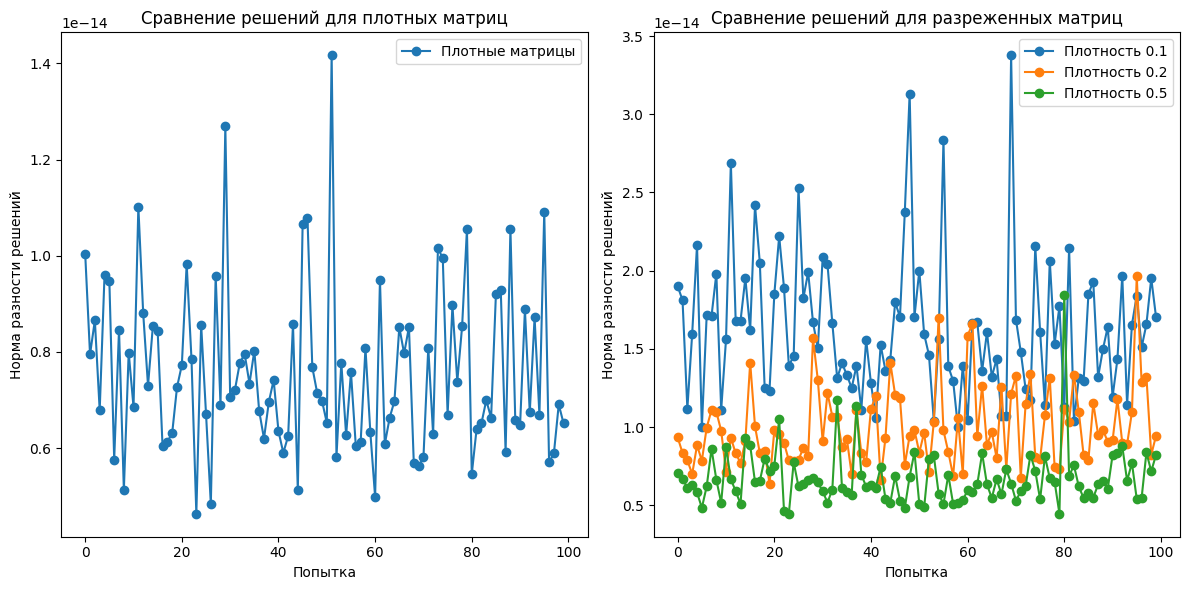

In [125]:
num_trials = 100
densities = [0.1, 0.2, 0.5]  
results = {'dense': [], 'sparse': {density: [] for density in densities}}

# Сравнение на плотных матрицах
for _ in range(num_trials):
    A_dense = np.random.rand(100, 80) 
    b_dense = np.random.rand(100)
    
    
    x_ls_svd_dense = pseudo_inverse_svd(A_dense)@ b_dense
    
   
    x_ls_qr_dense = least_squares_solution_qr(A_dense, b_dense)
    
    
    results['dense'].append((np.linalg.norm(x_ls_svd_dense - x_ls_qr_dense)))

# Сравнение на разреженных матрицах
for density in densities:
    for _ in range(num_trials):
        A_sparse = generate_sparse_matrix(100, 80, density)
        b_sparse = np.random.rand(100)
        
       
        x_ls_svd_sparse = pseudo_inverse_svd(A_sparse.toarray())@ b_sparse
        
       
        x_ls_qr_sparse = least_squares_solution_qr(A_sparse.toarray(), b_sparse)
        
        
        results['sparse'][density].append(np.linalg.norm(x_ls_svd_sparse - x_ls_qr_sparse))


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(results['dense'], label='Плотные матрицы', marker='o')
plt.title('Сравнение решений для плотных матриц')
plt.xlabel('Попытка')
plt.ylabel('Норма разности решений')
plt.legend()


for density in densities:
    plt.subplot(1, 2, 2)
    plt.plot(results['sparse'][density], label=f'Плотность {density}', marker='o')

plt.title('Сравнение решений для разреженных матриц')
plt.xlabel('Попытка')
plt.ylabel('Норма разности решений')
plt.legend()

plt.tight_layout()
plt.show()

Чем больше плотность, тем ближе результат

#Задача 6*. Итерационное SVD.

Напишите свои собственные функции вычисления SVD простым итерационным методом и с помощью метода вращений Якоби. Сравните их работу с работой библиотечной функции numpy.linalg.svd.


**Описание методов.**

**1. Простой итерационный алгоритм**

Основная процедура — поиск наилучшего приближения произвольной $ m \times n$  матрицы $X=(x_{ij})$ матрицей вида $b \otimes a = (b_i a_j)$ (где b — m-мерный вектор, а a — n-мерный вектор) методом наименьших квадратов:


$F(b, a) = \frac{1}{2}\sum_{i=1}^m \sum_{j=1}^n (x_{ij} - b_i a_j )^2 \to \min$


Решение этой задачи дается последовательными итерациями по явным формулам. При фиксированном векторе $a=(a_j)$  значения $b=(b_i)$ , доставляющие минимум форме $F(b, a)$ , однозначно и явно определяются из равенств $\partial F/ \partial b_i = 0$ :

$\frac{\partial F}{\partial b_i}$ $= - \sum_{j=1}^n (x_{ij} - b_i a_j )a_j = 0$; $b_i = \frac{\sum_{j=1}^n x_{ij}  a_j}{\sum_{j=1}^n a_j^2 } $.


Аналогично, при фиксированном векторе $b =(b_ i)$  определяются значения $a=(a_j)$ :

$a_j = \frac{\sum_{i=1}^m b_i x_{ij} }{\sum_{i =1}^m b_i ^2 } $.


B качестве начального приближения вектора $a$ возьмем случайный вектор единичной длины, вычисляем вектор $b$, далее для этого вектора $b$ вычисляем вектор $a$ и т. д. Каждый шаг уменьшает значение $F(b, a)$ . В качестве критерия остановки используется малость относительного уменьшения значения минимизируемого функционала $F(b, a)$  за шаг итерации $(\Delta F / F )$ или малость самого значения $F$.

В результате для матрицы $X=(x_{ij})$ получили наилучшее приближение матрицей $P_1$ вида $b^1 \otimes a^1 = (b_i^1  a_j^1)$ (здесь верхним индексом обозначен номер итерации). Далее, из матрицы $X$ вычитаем полученную матрицу $P_1$, и для полученной матрицы уклонений $X_1=X-P_1$ вновь ищем наилучшее приближение $P_2 $этого же вида и т. д., пока, например, норма $X_k$ не станет достаточно малой. В результате получили итерационную процедуру разложения матрицы X в виде суммы матриц ранга 1, то есть $X=P_1+P_2+... +P_q $ $(P_l = b^l \otimes a^l) $ . Полагаем  $\sigma_l = \|a^l\| \|b^l\|$ и нормируем векторы  $a^l \, , \, b^l: a^l:= a^l/ \| a^l\|; \, \, b^l:= b^l/ \| b^l\| $. В результате получена аппроксимация сингулярных чисел $ \sigma_l$  и сингулярных векторов (правых —  $a^l$ и левых — $b^l$).

К достоинствам этого алгоритма относится его исключительная простота и возможность почти без изменений перенести его на данные с пробелами, а также взвешенные данные.

Существуют различные модификации базового алгоритма, улучшающие точность и устойчивость. Например, векторы главных компонент $a^l$ при разных $l$ должны быть ортогональны «по построению», однако при большом числе итерации (большая размерность, много компонент) малые отклонения от ортогональности накапливаются и может потребоваться специальная коррекция $a^l$ на каждом шаге, обеспечивающая его ортогональность ранее найденным главным компонентам.

**2. Метод Якоби.**

Метод Якоби (вращений)

На каждом шаге вычисляется вращение Якоби $J$, с помощью которого матрица $G^\top G$ неявно пересчитывается в $J^\top G^\top GJ$; вращение выбрано так, чтобы пара внедиагональных элементов из $G^\top G$ обратилась в нули в матрице $J^\top G^\top GJ$. При этом ни $G^\top G$, ни $J^\top G^\top GJ$ не вычисляются в явном виде; вместо них вычисляется матрица $GJ$. Поэтому алгоритм называется методом односторонних вращений.

Пусть $a_{ij}$ - элемент, расположенный в i-ой строке и j-ом столбце матрицы $G^\top G$.

$τ=(a_{jj}−a_{kk})/(2⋅a_{jk})$

$t=\frac{sign(τ)}{|\tau| + \sqrt{1 + \tau^2}}$. При $τ=0$ считаем $sign(τ)=1$, то есть $θ=\frac{\pi}{4}$.

$c=\frac{1}{\sqrt{1 + t^2}}$, где $c=cosθ$

$s=c⋅t$, где $s=sinθ$

$G=G⋅R(j,k,θ)$

$J=J⋅R(j,k,θ)$

Здесь $R(j,k,θ)$ — матрица вращений Якоби, которая имеет следующий вид:




Одностороннее вращение Якоби в координатной плоскости $i,j$ вычисляется в том случае, если элемент $a_{ij}$ удовлетворяет условию: $|a_{ij}| ≥ε\sqrt{a_{ii}a_{jj}}$.